# 1. Data reading and exploration

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC

In [3]:
def get_sorted_files(directory):
    # List all files in the directory
    files = os.listdir(directory)
    # Sort files alphabetically
    files.sort()
    # Create full paths
    full_paths = [os.path.join(directory, file) for file in files]
    return full_paths

In [4]:
def read_hdf_variables(file_name):
    hdf = SD(file_name, SDC.READ)
    vars_data = []
    for ds_name in hdf.datasets().keys():
        dataset = hdf.select(ds_name)
        data = dataset.get()
        data = np.where(data == -1, np.nan, data)
        vars_data.append(data)
    hdf.end()
    vars_data = np.array(vars_data)
    return vars_data

In [5]:
def read_nc_variables(file_name, variable_name):
    era = xr.open_dataset(file_name)
    variable = era[variable_name]
    scale_factor = variable.attrs.get('scale_factor', 1)
    add_offset = variable.attrs.get('add_offset', 0)
    missing_value = variable.attrs.get('missing_value', None)
    _fill_value = variable.attrs.get('_FillValue', None)
    adjusted_variable = variable * scale_factor + add_offset
    if missing_value is not None:
        adjusted_variable = adjusted_variable.where(adjusted_variable != missing_value, other=np.nan)
    if _fill_value is not None:
        adjusted_variable = adjusted_variable.where(adjusted_variable != _fill_value, other=np.nan)
    return adjusted_variable

In [6]:
def stack_rad_from_files(directory):
    # Get sorted list of file paths
    file_paths = get_sorted_files(directory)
    # Initialize a list to hold arrays
    arrays = []
    i = 1
    # Loop over each file path, read data, and convert to array
    for file_path in file_paths:
        array = read_hdf_variables(file_path)
        print(i)
        i += 1
        # Resample array to fit ERA5 data and reduce memory requirements
        array_r = resample_dataset(array, lat_A, lon_A, lat_B, lon_B)
        arrays.append(array_r)
    # Stack arrays vertically
    stacked_array = np.vstack(arrays)
    return stacked_array

In [7]:
def stack_aod_from_files(directory):
    # Get sorted list of file paths
    file_paths = get_sorted_files(directory)
    # Initialize a list to hold arrays
    arrays = []
    i = 1
    # Loop over each file path, read data, and convert to array
    for file_path in file_paths:
        array = read_nc_variables(file_path, 'AODANA')
        print(i)
        i += 1
        # Resample array to fit ERA5 data and reduce memory requirements
        array_r = resample_dataset(array, lat_A, lon_A, lat_C, lon_C)
        arrays.append(array_r)
    # Stack arrays vertically
    stacked_array = np.vstack(arrays)
    return stacked_array

In [8]:
def stack_era_from_files(directory, variable_name):
    # Get sorted list of file paths
    file_paths = get_sorted_files(directory)
    # Initialize a list to hold arrays
    arrays = []
    i = 1
    # Loop over each file path, read data, and convert to array
    for file_path in file_paths:
        array = read_nc_variables(file_path, variable_name)[::3]
        print(i)
        i += 1
        arrays.append(array)
    # Stack arrays vertically
    stacked_array = np.vstack(arrays)
    return stacked_array

In [9]:
lat = read_nc_variables('/glade/campaign/work/yixinw/era-fal/e5.oper.an.sfc.128_243_fal.ll025sc.2022010100_2022013123.nc', 'latitude').values
lon = read_nc_variables('/glade/campaign/work/yixinw/era-fal/e5.oper.an.sfc.128_243_fal.ll025sc.2022010100_2022013123.nc', 'longitude').values

In [84]:
lat_a = read_nc_variables('/glade/campaign/work/yixinw/merra-aer/MERRA2_400.inst3_2d_gas_Nx.20220101.nc4', 'lat').values
lon_a = read_nc_variables('/glade/campaign/work/yixinw/merra-aer/MERRA2_400.inst3_2d_gas_Nx.20220101.nc4', 'lon').values

In [85]:
lat_A = lat
lon_A = lon
lat_B = np.arange(90, -90, -0.05)
lon_B = np.arange(-180, 180, 0.05)
lat_C = lat_a
lon_C = lon_a

In [121]:
from scipy.ndimage import zoom

def resample_dataset(data_B, lat_A, lon_A, lat_B, lon_B):
    """Resample Dataset B spatially to match Dataset A's resolution."""
    zoom_factor_lat = len(lat_A) / len(lat_B)
    zoom_factor_lon = len(lon_A) / len(lon_B)
    resampled_B = np.empty((data_B.shape[0], len(lat_A), len(lon_A)))
    for i in range(8):
        resampled_B[i] = zoom(data_B[i], (zoom_factor_lat, zoom_factor_lon), order=1)  # Using bilinear interpolation (order=1)
    return resampled_B

In [ ]:
dsr = stack_rad_from_files('/glade/campaign/work/yixinw/modis-dsr')

In [ ]:
par = stack_rad_from_files('/glade/campaign/work/yixinw/modis-par')

In [ ]:
aod = stack_aod_from_files('/glade/campaign/work/yixinw/merra-aer')

In [ ]:
fal = stack_era_from_files('/glade/campaign/work/yixinw/era-fal', 'FAL')

In [10]:
#era_shape = fal.shape
era_shape = (2920, 721, 1440)

In [ ]:
tcc = stack_era_from_files('/glade/campaign/work/yixinw/era-tcc', 'TCC')
tcw = stack_era_from_files('/glade/campaign/work/yixinw/era-tcw', 'TCW')
tco3 = stack_era_from_files('/glade/campaign/work/yixinw/era-tco3', 'TCO3')

In [11]:
lonm, latm = np.meshgrid(lon, lat)
lons = np.tile(lonm, (era_shape[0], 1, 1))
lats = np.tile(latm, (era_shape[0], 1, 1))
times = np.empty(era_shape)
for i in range(times.shape[0]):
    times[i] = i

In [87]:
# Convert longitudes from -180 to 180 range to 0 to 360 range
# ERA5: lat: 90_-90, lon: 0_360
# MODIS: lat: 90_-90, lon: -180_180
# MERRA2: lat: -90_90, lon: -180_180
# Need to be aligned to the same format (lat: 90_-90, lon: 0_360)

def convert_lon(arr):
    # Split the array into two parts along the last axis
    first_part = arr[:, :, :int(arr.shape[2]/2)]    # First 1000 elements
    last_part = arr[:, :, int(arr.shape[2]/2):]     # Last 1000 elements

    # Concatenate them in the reverse order
    rearranged_arr = np.concatenate((last_part, first_part), axis=2)

    return rearranged_arr

In [88]:
par_c = convert_lon(par)

In [ ]:
dsr_c = convert_lon(dsr)

In [ ]:
aod_c = convert_lon(aod)[:, ::-1, :]

In [12]:
# Select sub-domain to manage memory use (CONUS)
lon_sid = np.where((lon >= 235) & (lon <= 295))[0]
lat_sid = np.where((lat >= 25) & (lat <= 50))[0]

In [ ]:
fal_s = fal[:, lat_sid, :][:, :, lon_sid]
tcc_s = tcc[:, lat_sid, :][:, :, lon_sid]
tcw_s = tcw[:, lat_sid, :][:, :, lon_sid]
tco3_s = tco3[:, lat_sid, :][:, :, lon_sid]
aod_s = aod_c[:, lat_sid, :][:, :, lon_sid]

In [13]:
lats_s = lats[:, lat_sid, :][:, :, lon_sid]
lons_s = lons[:, lat_sid, :][:, :, lon_sid]
times_s = times[:, lat_sid, :][:, :, lon_sid]

In [89]:
par_s = par_c[:, lat_sid, :][:, :, lon_sid]

In [ ]:
dsr_s = dsr_c[:, lat_sid, :][:, :, lon_sid]

In [14]:
lat_s = lats_s[0]
lon_s = lons_s[0]

In [ ]:
np.save('/glade/campaign/work/yixinw/fal.npy', fal_s)
np.save('/glade/campaign/work/yixinw/tcc.npy', tcc_s)
np.save('/glade/campaign/work/yixinw/tcw.npy', tcw_s)
np.save('/glade/campaign/work/yixinw/tco3.npy', tco3_s)
np.save('/glade/campaign/work/yixinw/aod.npy', aod_s)
np.save('/glade/campaign/work/yixinw/lats.npy', lats_s)
np.save('/glade/campaign/work/yixinw/lons.npy', lons_s)
np.save('/glade/campaign/work/yixinw/times.npy', times_s)

In [90]:
np.save('/glade/campaign/work/yixinw/par.npy', par_s)

In [ ]:
np.save('/glade/campaign/work/yixinw/dsr.npy', dsr_s)

# 2. Data selection

In [15]:
fal_s = np.load('/glade/campaign/work/yixinw/fal.npy')
tcc_s = np.load('/glade/campaign/work/yixinw/tcc.npy')
tcw_s = np.load('/glade/campaign/work/yixinw/tcw.npy')
tco3_s = np.load('/glade/campaign/work/yixinw/tco3.npy')
aod_s = np.load('/glade/campaign/work/yixinw/aod.npy')
lats_s = np.load('/glade/campaign/work/yixinw/lats.npy')
lons_s = np.load('/glade/campaign/work/yixinw/lons.npy')
times_s = np.load('/glade/campaign/work/yixinw/times.npy')
par_s = np.load('/glade/campaign/work/yixinw/par.npy')
dsr_s = np.load('/glade/campaign/work/yixinw/dsr.npy')

In [16]:
#final_shape = fal_s.shape
final_shape = (2920, 101, 241)

In [17]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import transform

In [18]:
# Function to convert longitudes in geometries from -180 to 180 to 0 to 360
def shift_longitude(geom):
    if geom.is_empty:
        return geom
    if isinstance(geom, (Polygon, MultiPolygon)):
        return transform(lambda x, y: ((x + 360) % 360, y), geom)
    raise TypeError("Geometry type not supported")

In [19]:
# Load the global country boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for USA
na_countries = world[world['name'].isin(['United States of America'])]

# Apply the longitude shift to all geometries in the na_countries GeoDataFrame
na_countries['geometry'] = na_countries['geometry'].apply(shift_longitude)

# Initialize the mask with False values
na_mask = np.zeros(lon_s.shape, dtype=bool)

# Check if each point is contained in the geometries of USA
for idx in range(lat_s.size):
    point = Point(lon_s.flat[idx], lat_s.flat[idx])
    if any(na_countries.contains(point)):
        na_mask.flat[idx] = True

/glade/derecho/scratch/yixinw/tmp/ipykernel_93946/2069655522.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/glade/work/yixinw/conda-envs/my-env/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [20]:
def select_na_region(data_global):
    # Broadcasting the mask to match data_global dimensions
    # Ensure the mask is expanded correctly across the time dimension
    expanded_mask = np.tile(na_mask, (data_global.shape[0], 1, 1))
    
    # Apply the mask
    data_na = np.ma.masked_where(~expanded_mask, data_global)
    
    # Flatten the data
    data_na_flat = data_na.compressed()

    return data_na_flat

In [21]:
def select_na_region_u(data_global):
    # Broadcasting the mask to match data_global dimensions
    # Ensure the mask is expanded correctly across the time dimension
    expanded_mask = np.tile(na_mask, (data_global.shape[0], 1, 1))
    
    # Apply the mask
    data_na = np.ma.masked_where(~expanded_mask, data_global)
    
    return data_na

In [22]:
fal_na = select_na_region(fal_s)
tcc_na = select_na_region(tcc_s)
tcw_na = select_na_region(tcw_s)
tco3_na = select_na_region(tco3_s)
aod_na = select_na_region(aod_s)
lats_na = select_na_region(lats_s)
lons_na = select_na_region(lons_s)
times_na = select_na_region(times_s)
par_na = select_na_region(par_s)
dsr_na = select_na_region(dsr_s)

In [23]:
fal_nau = select_na_region_u(fal_s)
tcc_nau = select_na_region_u(tcc_s)
tcw_nau = select_na_region_u(tcw_s)
tco3_nau = select_na_region_u(tco3_s)
aod_nau = select_na_region_u(aod_s)
#lats_nau = select_na_region_u(lats_s)
#lons_nau = select_na_region_u(lons_s)
#times_nau = select_na_region_u(times_s)
par_nau = select_na_region_u(par_s)
dsr_nau = select_na_region_u(dsr_s)

In [115]:
# Identify indices where all data have non-NaN values
valid_idx = ~np.isnan(fal_na) & ~np.isnan(tcc_na) & ~np.isnan(tcw_na) & ~np.isnan(tco3_na) & ~np.isnan(aod_na) & ~np.isnan(par_na) & ~np.isnan(dsr_na) & (par_na!=0) & (dsr_na!=0)

In [116]:
# Flatten and filter
fal_f = fal_na[valid_idx]
tcc_f = tcc_na[valid_idx]
tcw_f = tcw_na[valid_idx]
tco3_f = tco3_na[valid_idx]
aod_f = aod_na[valid_idx]
par_f = par_na[valid_idx]
dsr_f = dsr_na[valid_idx]
#lats_f = np.sin(np.radians(lats[valid_idx]))
#lons_f = np.cos(np.radians(lons[valid_idx]))
lats_f = lats_na[valid_idx]
lons_f = lons_na[valid_idx]
times_f = times_na[valid_idx]

In [117]:
# Define parameters for slicing
take = 8 # 8 samples per 1 day
skip = 5*8 # 40 samples for 5 days

In [118]:
# Calculate indices to take
temp_val = np.concatenate([np.arange(start, start + take) for start in range(0, era_shape[0], take + skip)])

In [119]:
temp_mask = np.isin(times_f, temp_val)
temp_idx = np.where(temp_mask)[0]

In [120]:
# Final datasets are over CONUS for 2022
# Spatial resolution: 0.25deg * 0.25deg
# Temporal resolution: 3hr daily (with a 5dy interval between each sampling day)

fal_z = fal_f[temp_idx]
tcc_z = tcc_f[temp_idx]
tcw_z = tcw_f[temp_idx]
tco3_z = tco3_f[temp_idx]
aod_z = aod_f[temp_idx]
par_z = par_f[temp_idx]
dsr_z = dsr_f[temp_idx]
lats_z = lats_f[temp_idx]
lons_z = lons_f[temp_idx]
times_z = times_f[temp_idx]
#pdr_z = par_z/dsr_z

In [80]:
np.save('/glade/campaign/work/yixinw/fal_z.npy', fal_z)
np.save('/glade/campaign/work/yixinw/tcc_z.npy', tcc_z)
np.save('/glade/campaign/work/yixinw/tcw_z.npy', tcw_z)
np.save('/glade/campaign/work/yixinw/tco3_z.npy', tco3_z)
np.save('/glade/campaign/work/yixinw/aod_z.npy', aod_z)
np.save('/glade/campaign/work/yixinw/par_z.npy', par_z)
np.save('/glade/campaign/work/yixinw/dsr_z.npy', dsr_z)
np.save('/glade/campaign/work/yixinw/lats_z.npy', lats_z)
np.save('/glade/campaign/work/yixinw/lons_z.npy', lons_z)
np.save('/glade/campaign/work/yixinw/times_z.npy', times_z)
#np.save('/glade/campaign/work/yixinw/pdr_z.npy', pdr_z)

In [81]:
fal_z = np.load('/glade/campaign/work/yixinw/fal_z.npy')
tcc_z = np.load('/glade/campaign/work/yixinw/tcc_z.npy')
tcw_z = np.load('/glade/campaign/work/yixinw/tcw_z.npy')
tco3_z = np.load('/glade/campaign/work/yixinw/tco3_z.npy')
aod_z = np.load('/glade/campaign/work/yixinw/aod_z.npy')
par_z = np.load('/glade/campaign/work/yixinw/par_z.npy')
dsr_z = np.load('/glade/campaign/work/yixinw/dsr_z.npy')
lats_z = np.load('/glade/campaign/work/yixinw/lats_z.npy')
lons_z = np.load('/glade/campaign/work/yixinw/lons_z.npy')
times_z = np.load('/glade/campaign/work/yixinw/times_z.npy')
#pdr_z = np.load('/glade/campaign/work/yixinw/pdr_z.npy')

In [31]:
# Calculate indices to take (for evaluation purpose)
temp_val_u = np.concatenate([np.arange(start, start + take) for start in range(16, era_shape[0], take + skip)])

In [32]:
fal_tu = fal_s[temp_val_u].flatten()
tcc_tu = tcc_s[temp_val_u].flatten()
tcw_tu = tcw_s[temp_val_u].flatten()
tco3_tu = tco3_s[temp_val_u].flatten()
aod_tu = aod_s[temp_val_u].flatten()
par_tu = par_s[temp_val_u].flatten()
dsr_tu = dsr_s[temp_val_u].flatten()

In [33]:
fal_or = fal_s[temp_val]
tcc_or = tcc_s[temp_val]
tcw_or = tcw_s[temp_val]
tco3_or = tco3_s[temp_val]
aod_or = aod_s[temp_val]
par_or = par_s[temp_val]
dsr_or = dsr_s[temp_val]

In [44]:
np.save('/glade/campaign/work/yixinw/fal_or.npy', fal_or)
np.save('/glade/campaign/work/yixinw/tcc_or.npy', tcc_or)
np.save('/glade/campaign/work/yixinw/tcw_or.npy', tcw_or)
np.save('/glade/campaign/work/yixinw/tco3_or.npy', tco3_or)
np.save('/glade/campaign/work/yixinw/aod_or.npy', aod_or)
np.save('/glade/campaign/work/yixinw/par_or.npy', par_or)
np.save('/glade/campaign/work/yixinw/dsr_or.npy', dsr_or)

In [15]:
fal_or = np.load('/glade/campaign/work/yixinw/fal_or.npy')
tcc_or = np.load('/glade/campaign/work/yixinw/tcc_or.npy')
tcw_or = np.load('/glade/campaign/work/yixinw/tcw_or.npy')
tco3_or = np.load('/glade/campaign/work/yixinw/tco3_or.npy')
aod_or = np.load('/glade/campaign/work/yixinw/aod_or.npy')
par_or = np.load('/glade/campaign/work/yixinw/par_or.npy')
dsr_or = np.load('/glade/campaign/work/yixinw/dsr_or.npy')

In [34]:
# Identify indices where all data have NaN values
valid_idx_u = np.isnan(fal_tu) | np.isnan(tcc_tu) | np.isnan(tcw_tu) | np.isnan(tco3_tu) | np.isnan(aod_tu) | np.isnan(par_tu) | np.isnan(dsr_tu)

In [35]:
#eval_shape = fal_s[temp_val_u].shape
eval_shape = (488, 101, 241)

In [36]:
fal_tu[valid_idx_u] = 0
tcc_tu[valid_idx_u] = 0
tcw_tu[valid_idx_u] = 0
tco3_tu[valid_idx_u] = 0
aod_tu[valid_idx_u] = 0
par_tu[valid_idx_u] = 0
dsr_tu[valid_idx_u] = 0

In [55]:
np.save('/glade/campaign/work/yixinw/fal_eval.npy', fal_tu)
np.save('/glade/campaign/work/yixinw/tcc_eval.npy', tcc_tu)
np.save('/glade/campaign/work/yixinw/tcw_eval.npy', tcw_tu)
np.save('/glade/campaign/work/yixinw/tco3_eval.npy', tco3_tu)
np.save('/glade/campaign/work/yixinw/aod_eval.npy', aod_tu)
np.save('/glade/campaign/work/yixinw/par_eval.npy', par_tu)
np.save('/glade/campaign/work/yixinw/dsr_eval.npy', dsr_tu)

In [16]:
fal_tu = np.load('/glade/campaign/work/yixinw/fal_eval.npy')
tcc_tu = np.load('/glade/campaign/work/yixinw/tcc_eval.npy')
tcw_tu = np.load('/glade/campaign/work/yixinw/tcw_eval.npy')
tco3_tu = np.load('/glade/campaign/work/yixinw/tco3_eval.npy')
aod_tu = np.load('/glade/campaign/work/yixinw/aod_eval.npy')
par_tu = np.load('/glade/campaign/work/yixinw/par_eval.npy')
dsr_tu = np.load('/glade/campaign/work/yixinw/dsr_eval.npy')

# 3. Neural network construction and training

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner import RandomSearch, BayesianOptimization, HyperParameters
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2024-05-07 23:05:59.279578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 23:05:59.279610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 23:05:59.280926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 23:05:59.287677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:
# Stacking features into a single matrix
X_direct = np.stack([dsr_z, fal_z, tcc_z, tcw_z, tco3_z, aod_z]).T  # Direct features
y = par_z  # Target variable

# Splitting the data into training, validation, and test sets
total_idx = range(len(X_direct))
train_total_idx, test_idx = train_test_split(total_idx, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_total_idx, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

X_direct_train_total, X_direct_train, X_direct_val, X_direct_test = X_direct[train_total_idx], X_direct[train_idx], X_direct[val_idx], X_direct[test_idx]
y_train_total, y_train, y_val, y_test = y[train_total_idx], y[train_idx], y[val_idx], y[test_idx]
#lat_train, lat_val, lat_test = lats_f[train_idx], lats_f[val_idx], lats_f[test_idx]
#lon_train, lon_val, lon_test = lons_f[train_idx], lons_f[val_idx], lons_f[test_idx]

In [83]:
np.save('/glade/campaign/work/yixinw/x_train_total.npy', X_direct_train_total)
np.save('/glade/campaign/work/yixinw/x_train.npy', X_direct_train)
np.save('/glade/campaign/work/yixinw/x_val.npy', X_direct_val)
np.save('/glade/campaign/work/yixinw/x_test.npy', X_direct_test)
np.save('/glade/campaign/work/yixinw/y_train_total.npy', y_train_total)
np.save('/glade/campaign/work/yixinw/y_train.npy', y_train)
np.save('/glade/campaign/work/yixinw/y_val.npy', y_val)
np.save('/glade/campaign/work/yixinw/y_test.npy', y_test)

In [84]:
X_direct_train_total = np.load('/glade/campaign/work/yixinw/x_train_total.npy')
X_direct_train = np.load('/glade/campaign/work/yixinw/x_train.npy')
X_direct_val = np.load('/glade/campaign/work/yixinw/x_val.npy')
X_direct_test = np.load('/glade/campaign/work/yixinw/x_test.npy')
y_train_total = np.load('/glade/campaign/work/yixinw/y_train_total.npy')
y_train = np.load('/glade/campaign/work/yixinw/y_train.npy')
y_val = np.load('/glade/campaign/work/yixinw/y_val.npy')
y_test = np.load('/glade/campaign/work/yixinw/y_test.npy')

In [104]:
# Data Preprocessing: Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training data
X_direct_train_total_scaled = scaler_X.fit_transform(X_direct_train_total)
#X_direct_train_scaled = np.hstack((X_direct_train_scaled, lat_train.reshape(-1, 1), lon_train.reshape(-1, 1)))
y_train_total_scaled = scaler_y.fit_transform(y_train_total.reshape(-1, 1))

# Apply the same transformation to validation and test data
X_direct_train_scaled = scaler_X.transform(X_direct_train)
X_direct_val_scaled = scaler_X.transform(X_direct_val)
#X_direct_val_scaled = np.hstack((X_direct_val_scaled, lat_val.reshape(-1, 1), lon_val.reshape(-1, 1)))
X_direct_test_scaled = scaler_X.transform(X_direct_test)
#X_direct_test_scaled = np.hstack((X_direct_test_scaled, lat_test.reshape(-1, 1), lon_test.reshape(-1, 1)))
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [45]:
# Stacking features into a single matrix (for evaluation purpose)
X_eval = np.stack([dsr_tu, fal_tu, tcc_tu, tcw_tu, tco3_tu, aod_tu]).T  # Direct features
y_eval = par_tu  # Target variable

X_eval_scaled = scaler_X.transform(X_eval)
y_eval_scaled = scaler_y.transform(y_eval.reshape(-1, 1))

In [6]:
class ann_mse:

    def create_par_prediction_model_mse(self, hp):
        # Inputs
        direct_input = Input(shape=(6,), name='direct_input')

        # Hyperparameters
        optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        layers = hp.Int('layers', min_value=1, max_value=4, step=1)

        # Model construction with multiple layers
        x = direct_input
        for i in range(layers):
            units = hp.Int('units_' + str(i), min_value=16, max_value=128, step=16)
            activation = hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])
            dropout_rate = hp.Float('dropout_' + str(i), min_value=0, max_value=0.5, step=0.1)
            x = Dense(units, activation=activation, name=f'hidden_layer_{i}')(x)
            if dropout_rate > 0:
                x = Dropout(rate=dropout_rate, name=f'dropout_layer_{i}')(x)

        # Output layer
        output = Dense(1, activation='linear', name='output')(x)

        # Create and compile the model
        model = Model(inputs=direct_input, outputs=output)
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        else:
            opt = SGD(learning_rate=learning_rate)
        model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

        return model

# Define a model-building function for Keras Tuner
def build_model_mse(hp):
    ann_model_mse = ann_mse()
    batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)
    model = ann_model_mse.create_par_prediction_model_mse(hp)
    return model

In [7]:
class ann_mae:

    def create_par_prediction_model_mae(self, hp):
        # Inputs
        direct_input = Input(shape=(6,), name='direct_input')

        # Hyperparameters
        optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        layers = hp.Int('layers', min_value=1, max_value=4, step=1)

        # Model construction with multiple layers
        x = direct_input
        for i in range(layers):
            units = hp.Int('units_' + str(i), min_value=16, max_value=128, step=16)
            activation = hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])
            dropout_rate = hp.Float('dropout_' + str(i), min_value=0, max_value=0.5, step=0.1)
            x = Dense(units, activation=activation, name=f'hidden_layer_{i}')(x)
            if dropout_rate > 0:
                x = Dropout(rate=dropout_rate, name=f'dropout_layer_{i}')(x)

        # Output layer
        output = Dense(1, activation='linear', name='output')(x)

        # Create and compile the model
        model = Model(inputs=direct_input, outputs=output)
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        else:
            opt = SGD(learning_rate=learning_rate)
        model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error'])

        return model

# Define a model-building function for Keras Tuner
def build_model_mae(hp):
    ann_model_mae = ann_mae()
    batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)
    model = ann_model_mae.create_par_prediction_model_mae(hp)
    return model

In [8]:
# Include early stopping callback to save tuning time
early_stopping_1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [9]:
# Set up the tuner
tuner_mse = BayesianOptimization(
    hypermodel=build_model_mse,
    objective='val_loss',
    alpha=0.0001,
    beta=2.6,
    seed=123,
    max_trials=50,  # Reduced number of trials
    executions_per_trial=1,
    directory='model_tuning_mse',
    project_name='full_par_prediction_mse'
)

# Check if there is an existing tuning session to resume
if os.path.exists('/glade/campaign/work/yixinw/model_tuning_mse/full_par_prediction_mse/tuner0.json'):
    tuner_mse.reload()

Reloading Tuner from model_tuning_mse/full_par_prediction_mse/tuner0.json


In [10]:
# Set up the tuner
tuner_mae = BayesianOptimization(
    hypermodel=build_model_mae,
    objective='val_loss',
    alpha=0.0001,
    beta=2.6,
    seed=123,
    max_trials=50,  # Reduced number of trials
    executions_per_trial=1,
    directory='model_tuning_mae',
    project_name='full_par_prediction_mae'
)

# Check if there is an existing tuning session to resume
if os.path.exists('/glade/campaign/work/yixinw/model_tuning_mae/full_par_prediction_mae/tuner0.json'):
    tuner_mae.reload()

Reloading Tuner from model_tuning_mae/full_par_prediction_mae/tuner0.json


In [11]:
tuner_mse.search_space_summary()

Search space summary
Default search space size: 16
batch_size (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
a

In [55]:
tuner_mae.search_space_summary()

Search space summary
Default search space size: 16
batch_size (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
a

In [12]:
# Start the hyperparameter search with early stopping
tuner_mse.search(X_direct_train_scaled, y_train_scaled, epochs=10,  # Reduced epochs
                 validation_data=(X_direct_val_scaled, y_val_scaled), callbacks=[early_stopping_1],
                 batch_size=None, verbose=2)

Trial 50 Complete [00h 16m 42s]
val_loss: 0.0007766808266751468

Best val_loss So Far: 0.000758927664719522
Total elapsed time: 17h 04m 31s


In [6]:
tuner_mse.results_summary()

Results summary
Results in model_tuning_mse/full_par_prediction_mse
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 21 summary
Hyperparameters:
batch_size: 256
optimizer: adam
learning_rate: 0.000391418651512108
layers: 1
units_0: 64
activation_0: relu
dropout_0: 0.0
units_1: 48
activation_1: sigmoid
dropout_1: 0.1
units_2: 80
activation_2: sigmoid
dropout_2: 0.2
units_3: 48
activation_3: relu
dropout_3: 0.0
Score: 0.000758927664719522

Trial 49 summary
Hyperparameters:
batch_size: 192
optimizer: adam
learning_rate: 0.00032213139246717597
layers: 2
units_0: 48
activation_0: tanh
dropout_0: 0.0
units_1: 128
activation_1: tanh
dropout_1: 0.0
units_2: 80
activation_2: relu
dropout_2: 0.4
units_3: 16
activation_3: relu
dropout_3: 0.0
Score: 0.0007766808266751468

Trial 13 summary
Hyperparameters:
batch_size: 192
optimizer: adam
learning_rate: 1.5500421421811453e-05
layers: 3
units_0: 112
activation_0: tanh
dropout_0: 0.2
units_1: 32
activation_1: tanh
dropout_1: 0

In [11]:
# Start the hyperparameter search with early stopping
tuner_mae.search(X_direct_train_scaled, y_train_scaled, epochs=10,  # Reduced epochs
                 validation_data=(X_direct_val_scaled, y_val_scaled), callbacks=[early_stopping_1],
                 batch_size=None, verbose=2)

In [12]:
tuner_mae.results_summary()

Results summary
Results in model_tuning_mae/full_par_prediction_mae
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 21 summary
Hyperparameters:
batch_size: 256
optimizer: adam
learning_rate: 0.000391418651512108
layers: 1
units_0: 64
activation_0: relu
dropout_0: 0.0
units_1: 48
activation_1: sigmoid
dropout_1: 0.1
units_2: 80
activation_2: sigmoid
dropout_2: 0.2
units_3: 48
activation_3: relu
dropout_3: 0.0
Score: 0.014167831279337406

Trial 03 summary
Hyperparameters:
batch_size: 128
optimizer: sgd
learning_rate: 0.001129163728788601
layers: 2
units_0: 16
activation_0: tanh
dropout_0: 0.0
units_1: 80
activation_1: relu
dropout_1: 0.0
units_2: 32
activation_2: relu
dropout_2: 0.30000000000000004
Score: 0.014659826643764973

Trial 06 summary
Hyperparameters:
batch_size: 160
optimizer: sgd
learning_rate: 0.00041651428185674215
layers: 1
units_0: 48
activation_0: relu
dropout_0: 0.0
units_1: 112
activation_1: relu
dropout_1: 0.1
units_2: 64
activation_2: relu
dr

In [ ]:
# Get the best model and its hyperparameters
best_model_mse_1 = tuner_mse.get_best_models(num_models=7)[0]
best_model_mse_2 = tuner_mse.get_best_models(num_models=7)[6]

In [ ]:
best_model_mae_1 = tuner_mae.get_best_models(num_models=2)[0]
best_model_mae_2 = tuner_mae.get_best_models(num_models=2)[1]

In [14]:
# Use the optimal number of epochs found by the tuner for retraining
final_epochs = 50  # Set a reasonable epoch number (but larger than the tuning epoch)

In [17]:
# Retrain the best model with the optimal settings
history_mse_1 = best_model_mse_1.fit(X_direct_train_total_scaled, y_train_total_scaled,
                                     validation_split=0.25, shuffle=True,
                                     epochs=final_epochs, verbose=2, callbacks=[early_stopping_2])

Epoch 1/50
121859/121859 - 85s - loss: 7.6843e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 7.6843e-04 - val_loss: 7.6579e-04 - val_mean_absolute_error: 0.0162 - val_mean_squared_error: 7.6579e-04 - 85s/epoch - 698us/step
Epoch 2/50
121859/121859 - 83s - loss: 7.6733e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 7.6733e-04 - val_loss: 7.6101e-04 - val_mean_absolute_error: 0.0154 - val_mean_squared_error: 7.6101e-04 - 83s/epoch - 681us/step
Epoch 3/50
121859/121859 - 82s - loss: 7.6680e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 7.6680e-04 - val_loss: 7.6025e-04 - val_mean_absolute_error: 0.0152 - val_mean_squared_error: 7.6025e-04 - 82s/epoch - 673us/step
Epoch 4/50
121859/121859 - 83s - loss: 7.6517e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 7.6517e-04 - val_loss: 7.8229e-04 - val_mean_absolute_error: 0.0153 - val_mean_squared_error: 7.8229e-04 - 83s/epoch - 682us/step
Epoch 7/50
121859/121859 - 83s - loss: 7.6473e-04 - mean_absolute_error:

In [23]:
history_mse_2 = best_model_mse_2.fit(X_direct_train_total_scaled, y_train_total_scaled,
                                     validation_split=0.25, shuffle=True,
                                     epochs=final_epochs, verbose=2, callbacks=[early_stopping_2])

Epoch 1/50
121859/121859 - 85s - loss: 8.8239e-04 - mean_absolute_error: 0.0179 - mean_squared_error: 8.8239e-04 - val_loss: 8.7478e-04 - val_mean_absolute_error: 0.0178 - val_mean_squared_error: 8.7478e-04 - 85s/epoch - 695us/step
Epoch 2/50
121859/121859 - 83s - loss: 8.7097e-04 - mean_absolute_error: 0.0177 - mean_squared_error: 8.7097e-04 - val_loss: 8.6643e-04 - val_mean_absolute_error: 0.0176 - val_mean_squared_error: 8.6643e-04 - 83s/epoch - 685us/step
Epoch 3/50
121859/121859 - 84s - loss: 8.6139e-04 - mean_absolute_error: 0.0175 - mean_squared_error: 8.6139e-04 - val_loss: 8.5617e-04 - val_mean_absolute_error: 0.0174 - val_mean_squared_error: 8.5617e-04 - 84s/epoch - 686us/step
Epoch 4/50
121859/121859 - 83s - loss: 8.5323e-04 - mean_absolute_error: 0.0174 - mean_squared_error: 8.5323e-04 - val_loss: 8.4898e-04 - val_mean_absolute_error: 0.0173 - val_mean_squared_error: 8.4898e-04 - 83s/epoch - 681us/step
Epoch 5/50
121859/121859 - 84s - loss: 8.4641e-04 - mean_absolute_error:

In [19]:
history_mae_1 = best_model_mae_1.fit(X_direct_train_total_scaled, y_train_total_scaled,
                                     validation_split=0.25, shuffle=True,
                                     epochs=final_epochs, verbose=2, callbacks=[early_stopping_2])

Epoch 1/50
121859/121859 - 78s - loss: 0.0144 - mean_absolute_error: 0.0144 - mean_squared_error: 7.7618e-04 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144 - val_mean_squared_error: 7.7908e-04 - 78s/epoch - 641us/step
Epoch 2/50
121859/121859 - 78s - loss: 0.0144 - mean_absolute_error: 0.0144 - mean_squared_error: 7.7615e-04 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146 - val_mean_squared_error: 7.9187e-04 - 78s/epoch - 639us/step
Epoch 3/50
121859/121859 - 77s - loss: 0.0143 - mean_absolute_error: 0.0143 - mean_squared_error: 7.7596e-04 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144 - val_mean_squared_error: 7.6570e-04 - 77s/epoch - 630us/step
Epoch 4/50
121859/121859 - 78s - loss: 0.0143 - mean_absolute_error: 0.0143 - mean_squared_error: 7.7616e-04 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141 - val_mean_squared_error: 7.7288e-04 - 78s/epoch - 640us/step
Epoch 5/50
121859/121859 - 80s - loss: 0.0143 - mean_absolute_error: 0.0143 - mean_squared_error: 7.7605

In [26]:
history_mae_2 = best_model_mae_2.fit(X_direct_train_total_scaled, y_train_total_scaled,
                                     validation_split=0.25, shuffle=True,
                                     epochs=final_epochs, verbose=2, callbacks=[early_stopping_2])

Epoch 1/50
121859/121859 - 81s - loss: 0.0149 - mean_absolute_error: 0.0149 - mean_squared_error: 7.8448e-04 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148 - val_mean_squared_error: 7.7477e-04 - 81s/epoch - 665us/step
Epoch 2/50
121859/121859 - 84s - loss: 0.0149 - mean_absolute_error: 0.0149 - mean_squared_error: 7.8297e-04 - val_loss: 0.0145 - val_mean_absolute_error: 0.0145 - val_mean_squared_error: 7.8306e-04 - 84s/epoch - 690us/step
Epoch 3/50
121859/121859 - 82s - loss: 0.0148 - mean_absolute_error: 0.0148 - mean_squared_error: 7.8145e-04 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147 - val_mean_squared_error: 7.7369e-04 - 82s/epoch - 674us/step
Epoch 4/50
121859/121859 - 80s - loss: 0.0148 - mean_absolute_error: 0.0148 - mean_squared_error: 7.8051e-04 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147 - val_mean_squared_error: 7.7575e-04 - 80s/epoch - 660us/step
Epoch 5/50
121859/121859 - 83s - loss: 0.0148 - mean_absolute_error: 0.0148 - mean_squared_error: 7.7939

In [56]:
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [20]:
# Save the model
best_model_mse_1.save('final_ann_mse_1.h5')

# Save the history
with open('final_ann_history_mse_1.json', 'w') as f:
    json.dump(history_mse_1.history, f)

In [ ]:
# Save the model
best_model_mse_2.save('final_ann_mse_2.h5')

# Save the history
with open('final_ann_history_mse_2.json', 'w') as f:
    json.dump(history_mse_2.history, f)

In [23]:
# Save the model
best_model_mae_1.save('final_ann_mae_1.h5')

# Save the history
with open('final_ann_history_mae_1.json', 'w') as f:
    json.dump(history_mae_1.history, f)

In [ ]:
# Save the model
best_model_mae_2.save('final_ann_mae_2.h5')

# Save the history
with open('final_ann_history_mae_2.json', 'w') as f:
    json.dump(history_mae_2.history, f)

In [89]:
# Load the model
best_model_mse_1 = load_model('final_ann_mse_1.h5')  # Load the model

# Load the history
with open('final_ann_history_mse_1.json', 'r') as f:
    history_mse_1_h = json.load(f)

In [87]:
# Load the model
best_model_mse_2 = load_model('final_ann_mse_2.h5')  # Load the model

# Load the history
with open('final_ann_history_mse_2.json', 'r') as f:
    history_mse_2_h = json.load(f)

In [97]:
# Load the model
best_model_mae_1 = load_model('final_ann_mae_1.h5')  # Load the model

# Load the history
with open('final_ann_history_mae_1.json', 'r') as f:
    history_mae_1_h = json.load(f)

In [98]:
# Load the model
best_model_mae_2 = load_model('final_ann_mae_2.h5')  # Load the model

# Load the history
with open('final_ann_history_mae_2.json', 'r') as f:
    history_mae_2_h = json.load(f)

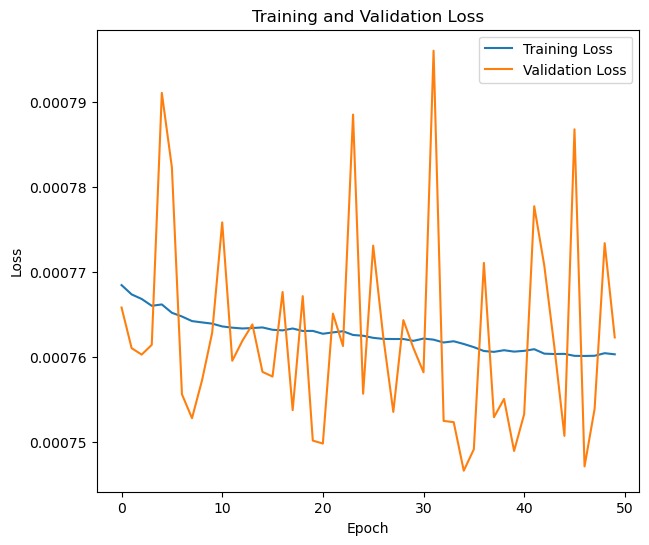

In [90]:
# Visualization of Loss vs. Epoch
plt.figure(figsize=(7, 6))

# Plot training and validation loss
plt.plot(history_mse_1_h['loss'], label='Training Loss')
plt.plot(history_mse_1_h['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('final_loss_epoch_ann_mse_1.pdf')

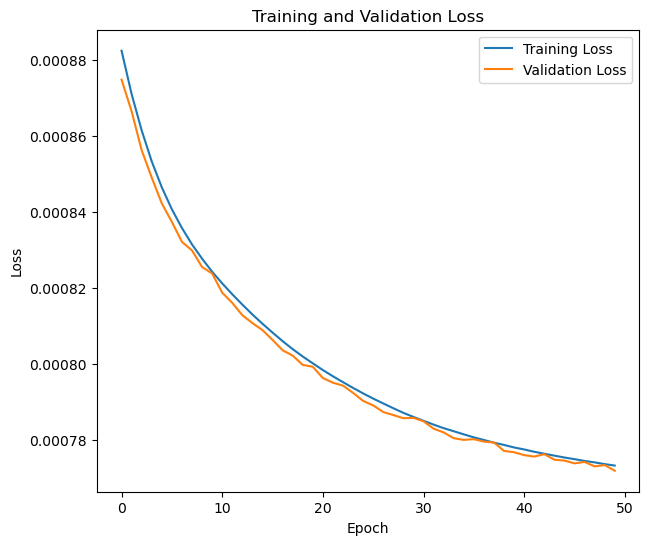

In [91]:
# Visualization of Loss vs. Epoch
plt.figure(figsize=(7, 6))

# Plot training and validation loss
plt.plot(history_mse_2_h['loss'], label='Training Loss')
plt.plot(history_mse_2_h['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('final_loss_epoch_ann_mse_2.pdf')

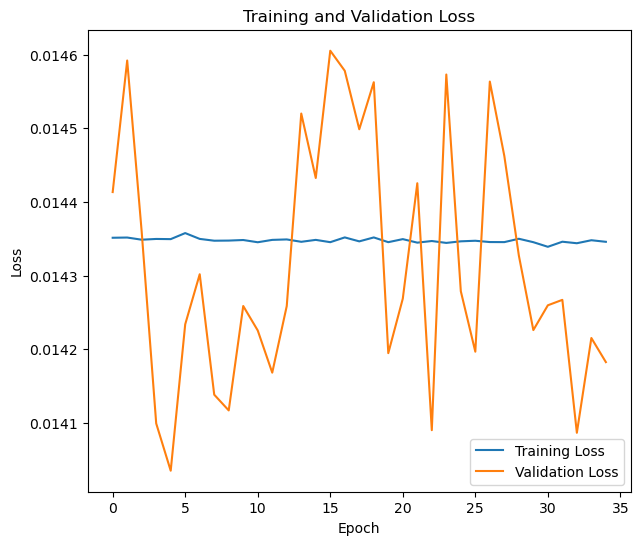

In [25]:
# Visualization of Loss vs. Epoch
plt.figure(figsize=(7, 6))

# Plot training and validation loss
plt.plot(history_mae_1_h['loss'], label='Training Loss')
plt.plot(history_mae_1_h['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('final_loss_epoch_ann_mae_1.pdf')

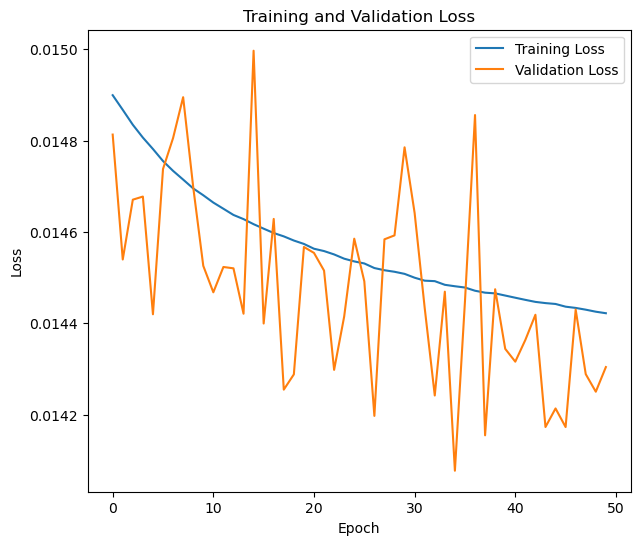

In [29]:
# Visualization of Loss vs. Epoch
plt.figure(figsize=(7, 6))

# Plot training and validation loss
plt.plot(history_mae_2_h['loss'], label='Training Loss')
plt.plot(history_mae_2_h['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('final_loss_epoch_ann_mae_2.pdf')

# 4. Evaluation

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [51]:
X_test_idx = np.where(X_direct_test[:, 0] == 0)[0]

In [93]:
# Train a baseline linear regression (LR) model with the same training set
lr_model = LinearRegression()
lr_model.fit(X_direct_train_total_scaled, y_train_total_scaled)

LinearRegression()

In [110]:
# Make predictions with LR
y_pred_lr_scaled = lr_model.predict(X_direct_test_scaled)

# Inverse transform the predictions to original scale
y_pred_lr = scaler_y.inverse_transform(y_pred_lr_scaled.reshape(-1, 1)).flatten()

# Calculate the error metrics for LR
# y_pred_lr[y_test==0] = 0
rmse_lr_c = root_mean_squared_error(y_test, y_pred_lr)
mae_lr_c = mean_absolute_error(y_test, y_pred_lr)
mape_lr_c = mean_absolute_percentage_error(y_test, y_pred_lr)
r2_lr_c = r2_score(y_test, y_pred_lr)
print((rmse_lr_c, mae_lr_c, mape_lr_c, r2_lr_c))

(5.783309456897529, 3.1865699919113926, 106.43809487629169, 0.997747856742229)


In [111]:
# Make predictions with ANN (MSE2)
y_pred_ann_scaled = best_model_mse_2.predict(X_direct_test_scaled)

# Inverse transform the predictions to original scale
y_pred_ann = scaler_y.inverse_transform(y_pred_ann_scaled.reshape(-1, 1)).flatten()

# Calculate the error metrics for ANN
# y_pred_ann[y_test==0] = 0
rmse_ann_c = root_mean_squared_error(y_test, y_pred_ann)
mae_ann_c = mean_absolute_error(y_test, y_pred_ann)
mape_ann_c = mean_absolute_percentage_error(y_test, y_pred_ann)
r2_ann_c = r2_score(y_test, y_pred_ann)
print((rmse_ann_c, mae_ann_c, mape_ann_c, r2_ann_c))

40620/40620 [==============================] - 21s 505us/step
(3.379473480440522, 1.7460695869720793, 2.7636631863524395, 0.9992309736247392)


In [124]:
X_eval_idx = np.where(np.all(X_eval == 0, axis=1))[0]

In [ ]:
# Make predictions with LR (for evaluation purpose)
y_eval_lr_scaled = lr_model.predict(X_eval_scaled)

# Inverse transform the predictions to original scale
y_eval_lr = scaler_y.inverse_transform(y_eval_lr_scaled.reshape(-1, 1)).flatten()
y_eval_lr[X_eval_idx] = 0

# Calculate the Mean Squared Error for LR
mse_eval_lr = mean_squared_error(y_eval, y_eval_lr)
print(mse_eval_lr)

In [ ]:
# Make predictions with ANN (MSE2) (for evaluation purpose)
y_eval_ann_scaled = best_model_mse_2.predict(X_eval_scaled)

# Inverse transform the predictions to original scale
y_eval_ann = scaler_y.inverse_transform(y_eval_ann_scaled.reshape(-1, 1)).flatten()
y_eval_ann[X_eval_idx] = 0

# Calculate the Mean Squared Error for ANN
mse_eval_ann = mean_squared_error(y_eval, y_eval_ann)
print(mse_eval_ann)

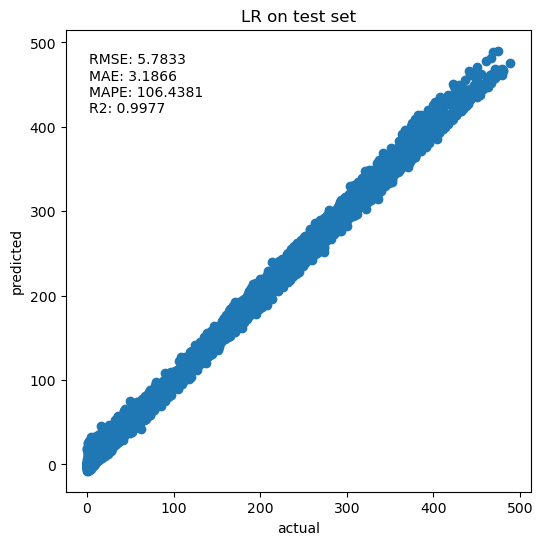

In [112]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test[:10000], y_pred_lr[:10000])
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('LR on test set')
plt.text(0.05, 0.95, f'RMSE: {rmse_lr_c:.4f}\nMAE: {mae_lr_c:.4f}\nMAPE: {mape_lr_c:.4f}\nR2: {r2_lr_c:.4f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.savefig('actual_predicted_lr.pdf')

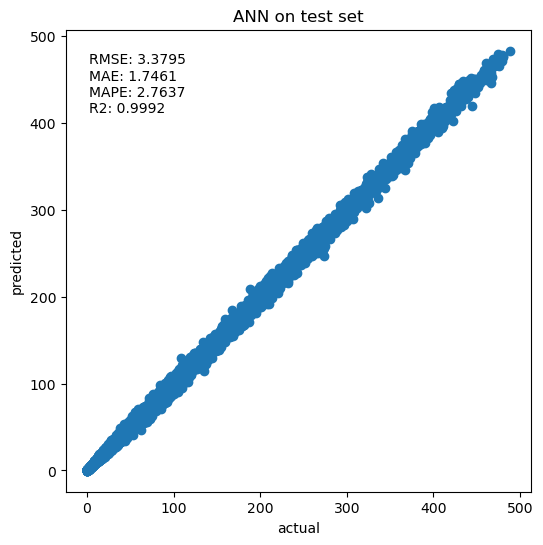

In [113]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test[:10000], y_pred_ann[:10000])
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('ANN on test set')
plt.text(0.05, 0.95, f'RMSE: {rmse_ann_c:.4f}\nMAE: {mae_ann_c:.4f}\nMAPE: {mape_ann_c:.4f}\nR2: {r2_ann_c:.4f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.savefig('actual_predicted_ann.pdf')

In [130]:
dsr_eval = dsr_tu.reshape(eval_shape)
fal_eval = fal_tu.reshape(eval_shape)
tcc_eval = tcc_tu.reshape(eval_shape)
tcw_eval = tcw_tu.reshape(eval_shape)
tco3_eval = tco3_tu.reshape(eval_shape)
aod_eval = aod_tu.reshape(eval_shape)

In [131]:
y_test_eval = y_eval.reshape(eval_shape)
y_lr_eval = y_eval_lr.reshape(eval_shape)
y_ann_eval = y_eval_ann.reshape(eval_shape)

In [132]:
dsr_eval_map = select_na_region_u(dsr_eval)
fal_eval_map = select_na_region_u(fal_eval)
tcc_eval_map = select_na_region_u(tcc_eval)
tcw_eval_map = select_na_region_u(tcw_eval)
tco3_eval_map = select_na_region_u(tco3_eval)
aod_eval_map = select_na_region_u(aod_eval)

In [133]:
y_test_eval_map = select_na_region_u(y_test_eval)
y_lr_eval_map = select_na_region_u(y_lr_eval)
y_ann_eval_map = select_na_region_u(y_ann_eval)

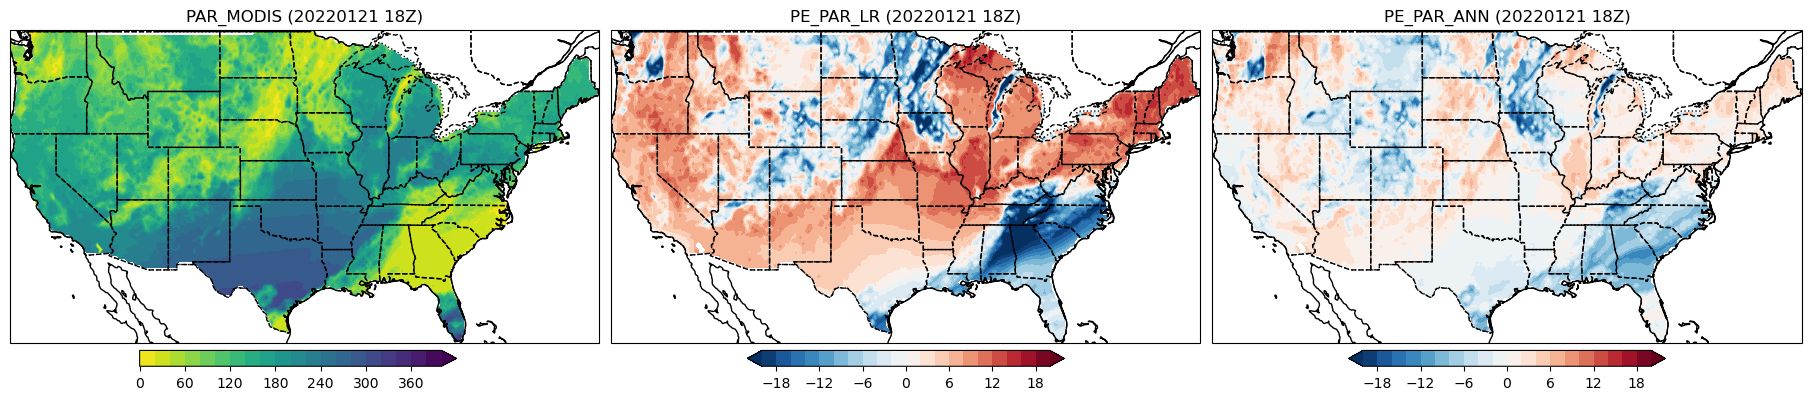

<Figure size 640x480 with 0 Axes>

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, y_test_eval_map[30], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 401, 20), extend='max')
        ax.set_title('PAR_MODIS (20220121 18Z)')
        #ax.text(-74, 22, '(W m-2)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, (y_lr_eval_map[30]-y_test_eval_map[30])/y_test_eval_map[30]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_LR (20220121 18Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, (y_ann_eval_map[30]-y_test_eval_map[30])/y_test_eval_map[30]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_ANN (20220121 18Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.02)

plt.show()
plt.tight_layout()
plt.savefig('20220121_18Z_PAR.png')

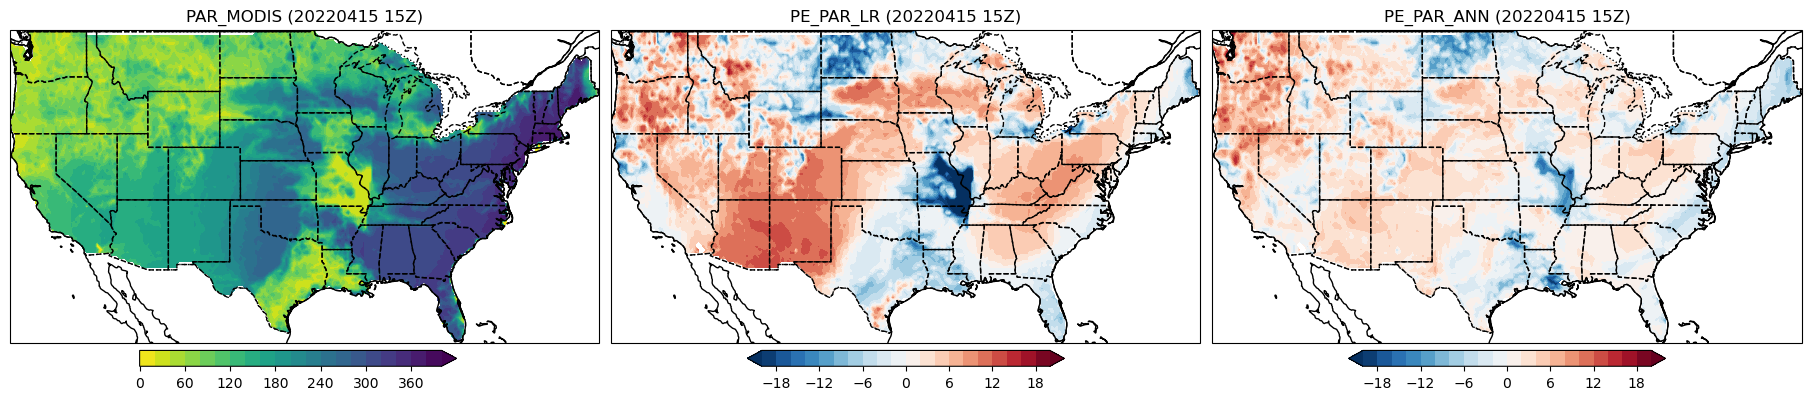

<Figure size 640x480 with 0 Axes>

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, y_test_eval_map[141], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 401, 20), extend='max')
        ax.set_title('PAR_MODIS (20220415 15Z)')
        #ax.text(-74, 22, '(W m-2)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, (y_lr_eval_map[141]-y_test_eval_map[141])/y_test_eval_map[141]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_LR (20220415 15Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, (y_ann_eval_map[141]-y_test_eval_map[141])/y_test_eval_map[141]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_ANN (20220415 15Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.02)

plt.show()
plt.tight_layout()
plt.savefig('20220415_15Z_PAR.png')

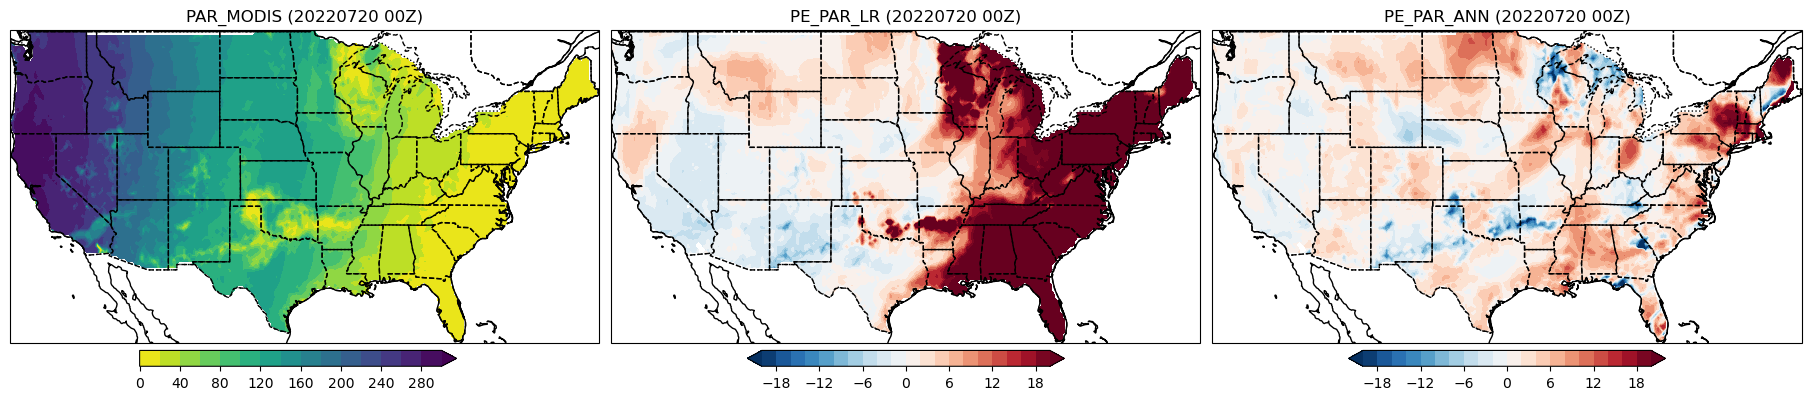

<Figure size 640x480 with 0 Axes>

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, y_test_eval_map[264], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220720 00Z)')
        #ax.text(-74, 22, '(W m-2)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, (y_lr_eval_map[264]-y_test_eval_map[264])/y_test_eval_map[264]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_LR (20220720 00Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, (y_ann_eval_map[264]-y_test_eval_map[264])/y_test_eval_map[264]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_ANN (20220720 00Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.02)

plt.show()
plt.tight_layout()
plt.savefig('20220720_00Z_PAR.png')

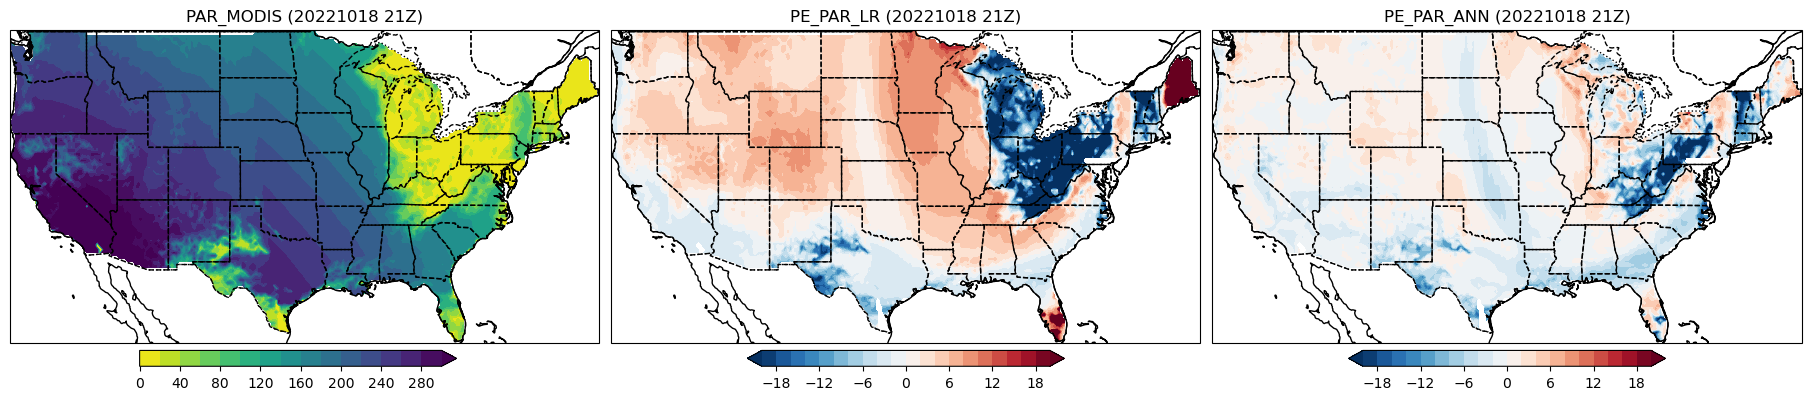

<Figure size 640x480 with 0 Axes>

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, y_test_eval_map[391], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20221018 21Z)')
        #ax.text(-74, 22, '(W m-2)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, (y_lr_eval_map[391]-y_test_eval_map[391])/y_test_eval_map[391]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_LR (20221018 21Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, (y_ann_eval_map[391]-y_test_eval_map[391])/y_test_eval_map[391]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_ANN (20221018 21Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.02)

plt.show()
plt.tight_layout()
plt.savefig('20221018_21Z_PAR.png')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, y_test_eval_map[30], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220105 18Z)')
        #ax.text(-74, 22, '(W m-2)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, (y_lr_eval_map[30]-y_test_eval_map[30])/y_test_eval_map[30]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_LR (20220105 18Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, (y_ann_eval_map[30]-y_test_eval_map[30])/y_test_eval_map[30]*100., cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=np.arange(-20, 21, 2), extend='both')
        ax.set_title('PE_PAR_ANN (20220105 18Z)')
        #ax.text(-74, 22, '(%)', transform=ccrs.Geodetic(), fontsize=12)
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.02)

plt.show()
plt.tight_layout()
plt.savefig('20220105_18Z_PAR.png')

In [51]:
dsr_or_map = select_na_region_u(dsr_or)
fal_or_map = select_na_region_u(fal_or)
tcc_or_map = select_na_region_u(tcc_or)
tcw_or_map = select_na_region_u(tcw_or)
tco3_or_map = select_na_region_u(tco3_or)
aod_or_map = select_na_region_u(aod_or)
par_or_map = select_na_region_u(par_or)

In [52]:
# Map plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[0], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20220101 00Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[0], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20220101 00Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[0], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20220101 00Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[0], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20220101 00Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[0], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20220101 00Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[0], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20220101 00Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[0], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220101 00Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20220101_00Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[6], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20220101 18Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[6], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20220101 18Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[6], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20220101 18Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[6], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20220101 18Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[6], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20220101 18Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[6], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20220101 18Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[6], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220101 18Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20220101_18Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[7], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20220101 21Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[7], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20220101 21Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[7], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20220101 21Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[7], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20220101 21Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[7], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20220101 21Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[7], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20220101 21Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[7], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220101 21Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20220101_21Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[8], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20220107 00Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[8], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20220107 00Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[8], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20220107 00Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[8], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20220107 00Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[8], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20220107 00Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[8], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20220107 00Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[8], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220107 00Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20220107_00Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[14], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20220107 18Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[14], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20220107 18Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[14], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20220107 18Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[14], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20220107 18Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[14], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20220107 18Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[14], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20220107 18Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[14], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220107 18Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20220107_18Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[15], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20220107 21Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[15], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20220107 21Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[15], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20220107 21Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[15], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20220107 21Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[15], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20220107 21Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[15], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20220107 21Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[15], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20220107 21Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20220107_21Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[-8], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20221227 00Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[-8], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20221227 00Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[-8], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20221227 00Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[-8], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20221227 00Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[-8], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20221227 00Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[-8], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20221227 00Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[-8], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20221227 00Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20221227_00Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[-2], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20221227 18Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[-2], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20221227 18Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[-2], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20221227 18Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[-2], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20221227 18Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[-2], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20221227 18Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[-2], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20221227 18Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[-2], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20221227 18Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20221227_18Z.png')

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        cf = ax.contourf(lon_s, lat_s, dsr_or_map[-1], cmap='cividis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20)*2, extend='max')
        ax.set_title('DSR_MODIS (20221227 21Z)')
    if i == 1:
        cf = ax.contourf(lon_s, lat_s, fal_or_map[-1], cmap='Greens', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('ALB_ERA5 (20221227 21Z)')
    if i == 2:
        cf = ax.contourf(lon_s, lat_s, tcc_or_map[-1], cmap='Oranges', transform=ccrs.PlateCarree(), levels=np.arange(0, 1.1, 0.1))
        ax.set_title('TCC_ERA5 (20221227 21Z)')
    if i == 3:
        cf = ax.contourf(lon_s, lat_s, tcw_or_map[-1], cmap='Blues', transform=ccrs.PlateCarree(), levels=np.arange(0, 41, 2), extend='max')
        ax.set_title('TCW_ERA5 (20221227 21Z)')
    if i == 4:
        cf = ax.contourf(lon_s, lat_s, tco3_or_map[-1], cmap='Greys', transform=ccrs.PlateCarree(), levels=np.arange(0.005, 0.011, 0.001), extend='both')
        ax.set_title('TCO3_ERA5 (20221227 21Z)')
    if i == 5:
        cf = ax.contourf(lon_s, lat_s, aod_or_map[-1], cmap='Reds', transform=ccrs.PlateCarree(), levels=np.arange(0, 0.61, 0.05), extend='max')
        ax.set_title('AOD_MERRA2 (20221227 21Z)')
    if i == 6:
        cf = ax.contourf(lon_s, lat_s, par_or_map[-1], cmap='viridis_r', transform=ccrs.PlateCarree(), levels=np.arange(0, 301, 20), extend='max')
        ax.set_title('PAR_MODIS (20221227 21Z)')
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.set_extent([-124.5, -67, 25, 45.5])

    # Add a colorbar for each subplot
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, extend='max')

plt.show()
plt.tight_layout()
plt.savefig('20221227_21Z.png')

# 5. Interpretation

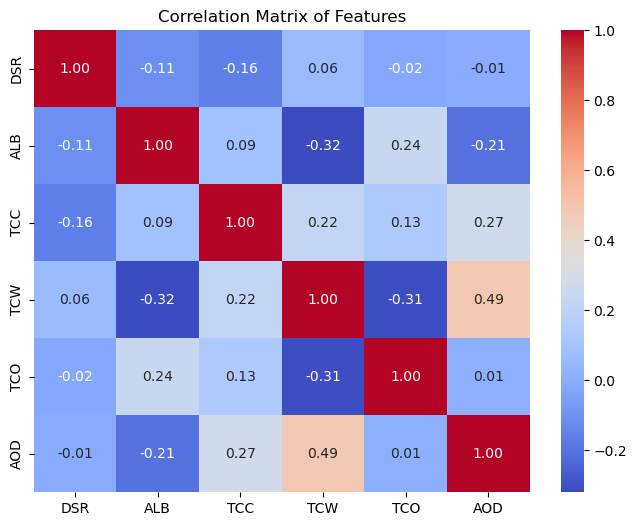

<Figure size 640x480 with 0 Axes>

In [49]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = np.corrcoef(X_direct_train_scaled.T)
feature_list = ['DSR', 'ALB', 'TCC', 'TCW', 'TCO', 'AOD']

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            xticklabels=[feature_list[i] for i in range(X_direct_train_scaled.shape[1])],
            yticklabels=[feature_list[i] for i in range(X_direct_train_scaled.shape[1])])
plt.title("Correlation Matrix of Features")
plt.show()
plt.savefig('correlation_features.pdf')

In [46]:
# LR model feature importance (coefficients)
feature_importance_lr = lr_model.coef_
print(feature_importance_lr)

[[ 0.99718592  0.00431604  0.00479515  0.03434477  0.00254745 -0.00150035]]


In [47]:
from sklearn.inspection import permutation_importance

# Permutation importance for both LR and ANN
perm_lr = permutation_importance(lr_model, X_direct_test_scaled, y_test_scaled, n_repeats=1, random_state=42, scoring='neg_mean_squared_error')
perm_lr_imp = perm_lr.importances_mean

perm_ann = permutation_importance(best_model_mse_2, X_direct_test_scaled, y_test_scaled, n_repeats=1, random_state=42, scoring='neg_mean_squared_error')
perm_ann_imp = perm_ann.importances_mean

40620/40620 [==============================] - 21s 505us/step


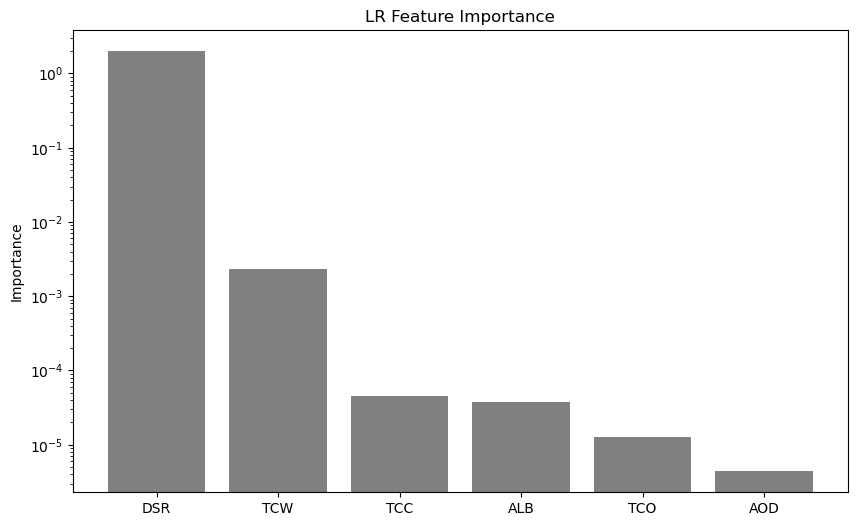

<Figure size 640x480 with 0 Axes>

In [53]:
# Sort the features by importance
perm_lr_idx = np.argsort(perm_lr_imp)[::-1]

plt.figure(figsize=(10, 6))
plt.title('LR Feature Importance')
plt.bar(range(X_direct_test_scaled.shape[1]), perm_lr_imp[perm_lr_idx], align='center', color='grey')
plt.xticks(range(X_direct_test_scaled.shape[1]), list(np.array(feature_list)[perm_lr_idx]))
plt.ylabel('Importance')
plt.yscale('log')
plt.show()
plt.savefig('feature_imp_lr.png')

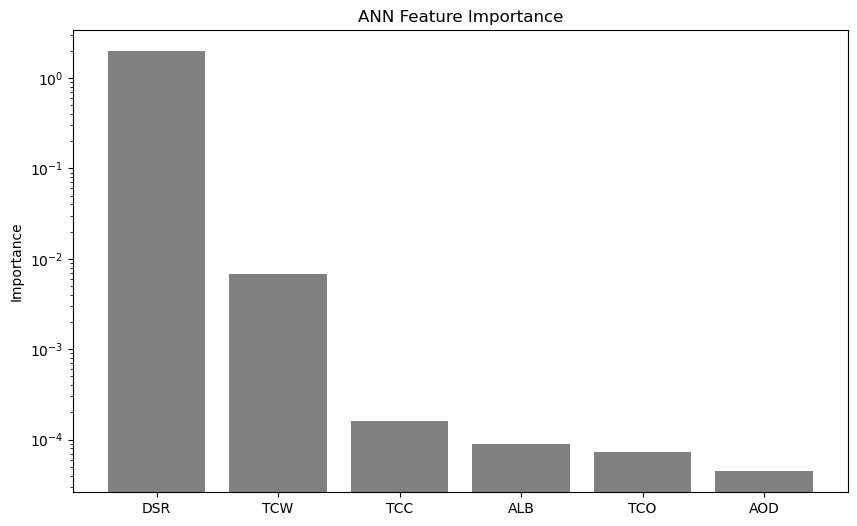

<Figure size 640x480 with 0 Axes>

In [54]:
# Sort the features by importance
perm_ann_idx = np.argsort(perm_ann_imp)[::-1]

plt.figure(figsize=(10, 6))
plt.title('ANN Feature Importance')
plt.bar(range(X_direct_test_scaled.shape[1]), perm_ann_imp[perm_ann_idx], align='center', color='grey')
plt.xticks(range(X_direct_test_scaled.shape[1]), list(np.array(feature_list)[perm_ann_idx]))
plt.ylabel('Importance')
plt.yscale('log')
plt.show()
plt.savefig('feature_imp_ann.png')